In [15]:
from os import getcwd, listdir
from os.path import join, dirname
from setfit import SetFitModel
from src.model import FCSTNet
import numpy as np
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, f1_score


PATH_DATA = join(getcwd(), 'data')
PATH_MODELS = join(getcwd(), 'models')

## 1. Let's load the validation dataset

We will compare our models using the validation dataset. 

We will forecast the data for each model and look at the metrics comparing predictions and ground truth labels

In [16]:
PATH_DATA = join(getcwd(), 'data')

val_data = pd.read_csv(join(PATH_DATA, 'val_hate.csv'))
texts = val_data.loc[:,'text'].values
labels = val_data.loc[:,'labels'].values

In [17]:
import json
  
# Opening JSON file
f = open(join(PATH_DATA, 'accs_bert.json'))
bert_accs = json.load(f)


f = open(join(PATH_DATA, 'f1s_bert.json'))
bert_f1s = json.load(f)


f = open(join(PATH_DATA, 'preds_prompt_llm_4.json'))
preds_llm = json.load(f)


## 2. Compute the Metrics 

We compute the metrics for each model!

In [18]:
accs = []
f1s = []
mapping = {'yes':1, 'no':0, "y'know":1}

for seed, preds_ in preds_llm.items():
    preds = [mapping[pred[0].lower()] for pred in preds_]

    accs.append(accuracy_score(val_data.labels.values, preds))
    f1s.append(f1_score(val_data.labels.values, preds))

accs_llm_4 = {'mean': np.mean(accs), 'std':np.std(accs)}
f1s_llm_4 = {'mean': np.mean(f1s), 'std':np.std(f1s)}


In [19]:


dirs = listdir(join(PATH_MODELS, 'setfit_hate_8'))
dirs2 = listdir(join(PATH_MODELS, 'st_standard_hate_8'))

accs_dict = {}
f1_dict = {}

accs_dict['bert'] = bert_accs
f1_dict['bert'] = bert_f1s


for model_name in ['setfit', 'setfit_head', 'st_standard']:
    accs_dict[model_name] = {}
    f1_dict[model_name] = {}
    for num_samples in [8, 16, 32, 64, 100]:
        accs = []
        f1 = []
        if 'setfit' in model_name:
            for dir in dirs:
                model = SetFitModel.from_pretrained(join(f"models/{model_name}_hate_{str(num_samples)}", dir), local_files_only=True)
                preds = model(texts)
                accs.append(accuracy_score(labels, preds))
                f1.append(f1_score(labels, preds))
        else:
            for dir in dirs2:
                model = FCSTNet(384)
                model.load_state_dict(torch.load(join(PATH_MODELS,f'{model_name}_hate_{str(num_samples)}', f'{dir}')))
                preds = model.predict(val_data.text.values.tolist()).detach().numpy()
                accs.append(accuracy_score(labels, preds))
                f1.append(f1_score(labels, preds))
        accs_dict[model_name][num_samples] = {}
        accs_dict[model_name][num_samples]['mean'] = np.mean(accs)
        accs_dict[model_name][num_samples]['std'] = np.std(accs)

        f1_dict[model_name][num_samples] = {}
        f1_dict[model_name][num_samples]['mean'] = np.mean(f1)
        f1_dict[model_name][num_samples]['std'] = np.std(f1)


## 3. Plot

Now let's plot the accuracy and f1 scores to compare the few shot learning models

### 3.1 Plotting Accuracy

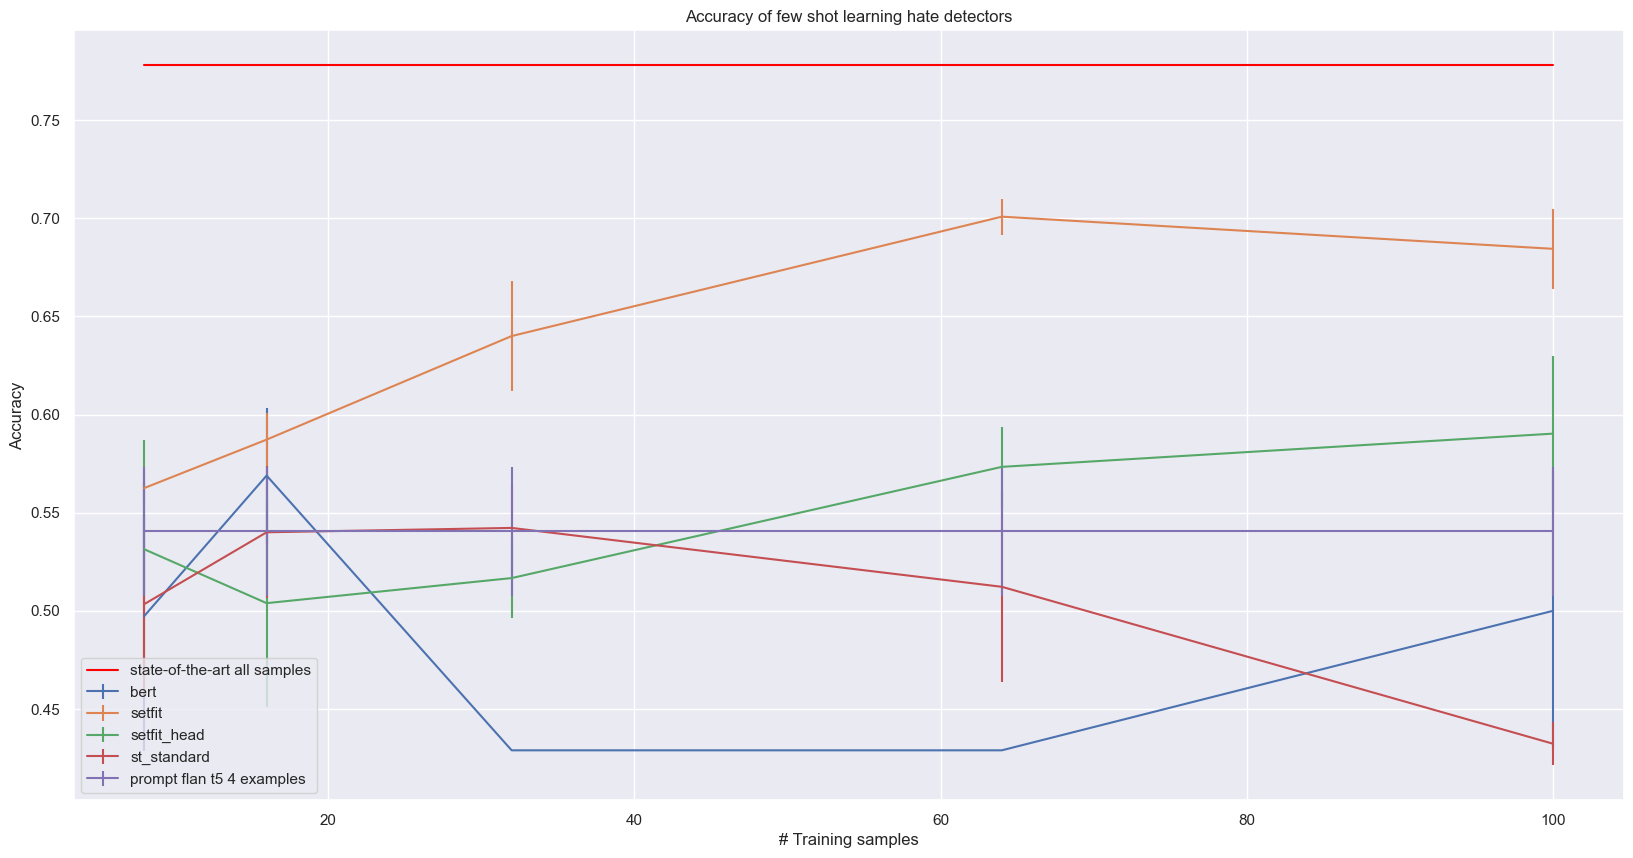

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

SOTA = 0.778

plt.rcParams["figure.figsize"] = (20,10)

x = [8, 16, 32, 64, 100]
fig, ax = plt.subplots()

for name_model, metrics in accs_dict.items():
    accs = []
    accs_std = []
    for seed_num, acc in metrics.items():
        accs.append(acc['mean'])
        accs_std.append(acc['std'])
    ax.errorbar(x, accs, accs_std, label=f'{name_model}')

ax.plot(x, len(x)*[SOTA], label= 'state-of-the-art all samples', color='red')
ax.errorbar(x, len(x)*[accs_llm_4['mean']], len(x)*[accs_llm_4['std']], label = 'prompt flan t5 4 examples')
ax.set_xlabel('# Training samples')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of few shot learning hate detectors')
plt.legend()
plt.show()

### 3.2 Plotting F1

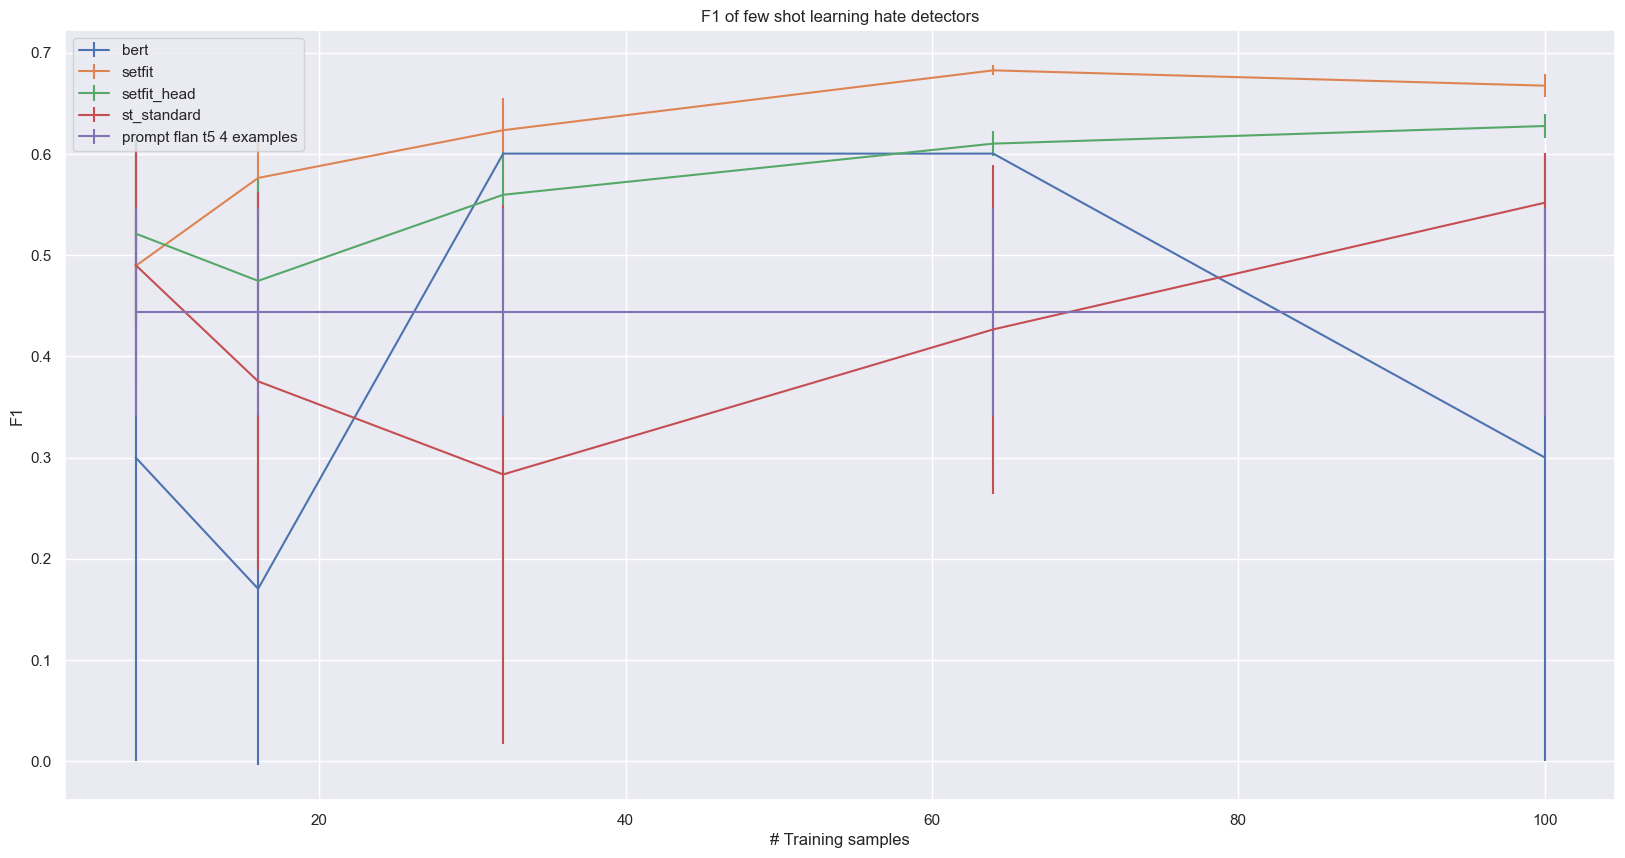

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

SOTA = 0.778

plt.rcParams["figure.figsize"] = (20,10)

x = [8, 16, 32, 64, 100]
fig, ax = plt.subplots()

for name_model, metrics in f1_dict.items():
    f1s = []
    f1s_std = []
    for seed_num, f1 in metrics.items():
        f1s.append(f1['mean'])
        f1s_std.append(f1['std'])

    ax.errorbar(x, f1s, f1s_std, label=f'{name_model}')
ax.errorbar(x, len(x)*[f1s_llm_4['mean']], len(x)*[f1s_llm_4['std']], label = 'prompt flan t5 4 examples')

ax.set_xlabel('# Training samples')
ax.set_ylabel('F1')
ax.set_title('F1 of few shot learning hate detectors')
plt.legend()
plt.show()